# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import scvi
import scrnatools as rna
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import ttest_ind, tukey_hsd

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

# Import data

In [5]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [6]:
# rawDataPath = "/mnt/e/Archive/Joe/raw_data/"
# processedDataPath = "/mnt/e/Archive/Joe/processed_data/"

In [7]:
adata = sc.read(f"{processedDataPath}/Fezf2_thymus_paper/h5ad_files/combined_all_genes_TECs_final.h5ad")
model = scvi.model.SCVI.load(f"{processedDataPath}/Fezf2_thymus_paper/scVI_models/combined_all_genes", adata=adata)

INFO     File /mnt/iacchus/joe/processed_data//Fezf2_thymus_paper/scVI_models/combined_all_genes/model.pt already  
         downloaded                                                                                                


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [8]:
# cellxgene epithelial cells
cell_x_gene_exprs = np.load(f"{processedDataPath}cell_x_gene_atlas/expression/cell_x_gene_atlas_expression.npy")
genes = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/keep_genes.csv")["feature_name"]
cells = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/obs_names.csv")['0']
metadata = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/cell_metadata.csv", index_col=0)
cell_x_gene_exprs = pd.DataFrame(cell_x_gene_exprs, columns=genes)
cell_x_gene_exprs["cell_type"] = metadata.cell_type.values
cell_x_gene_exprs = cell_x_gene_exprs[cell_x_gene_exprs.cell_type.str.contains("epithelial")]
del cell_x_gene_exprs["cell_type"]
adata = adata[:, adata.var_names.isin(cell_x_gene_exprs.columns)].copy()
cell_x_gene_exprs = cell_x_gene_exprs[adata.var_names].copy()

In [9]:
genes = pd.read_csv(f"{processedDataPath}cell_x_gene_atlas/expression/keep_genes.csv")["feature_name"]
adata = adata[:, adata.var_names.isin(genes)].copy()

# scVI num genes expressed

## pick threshold

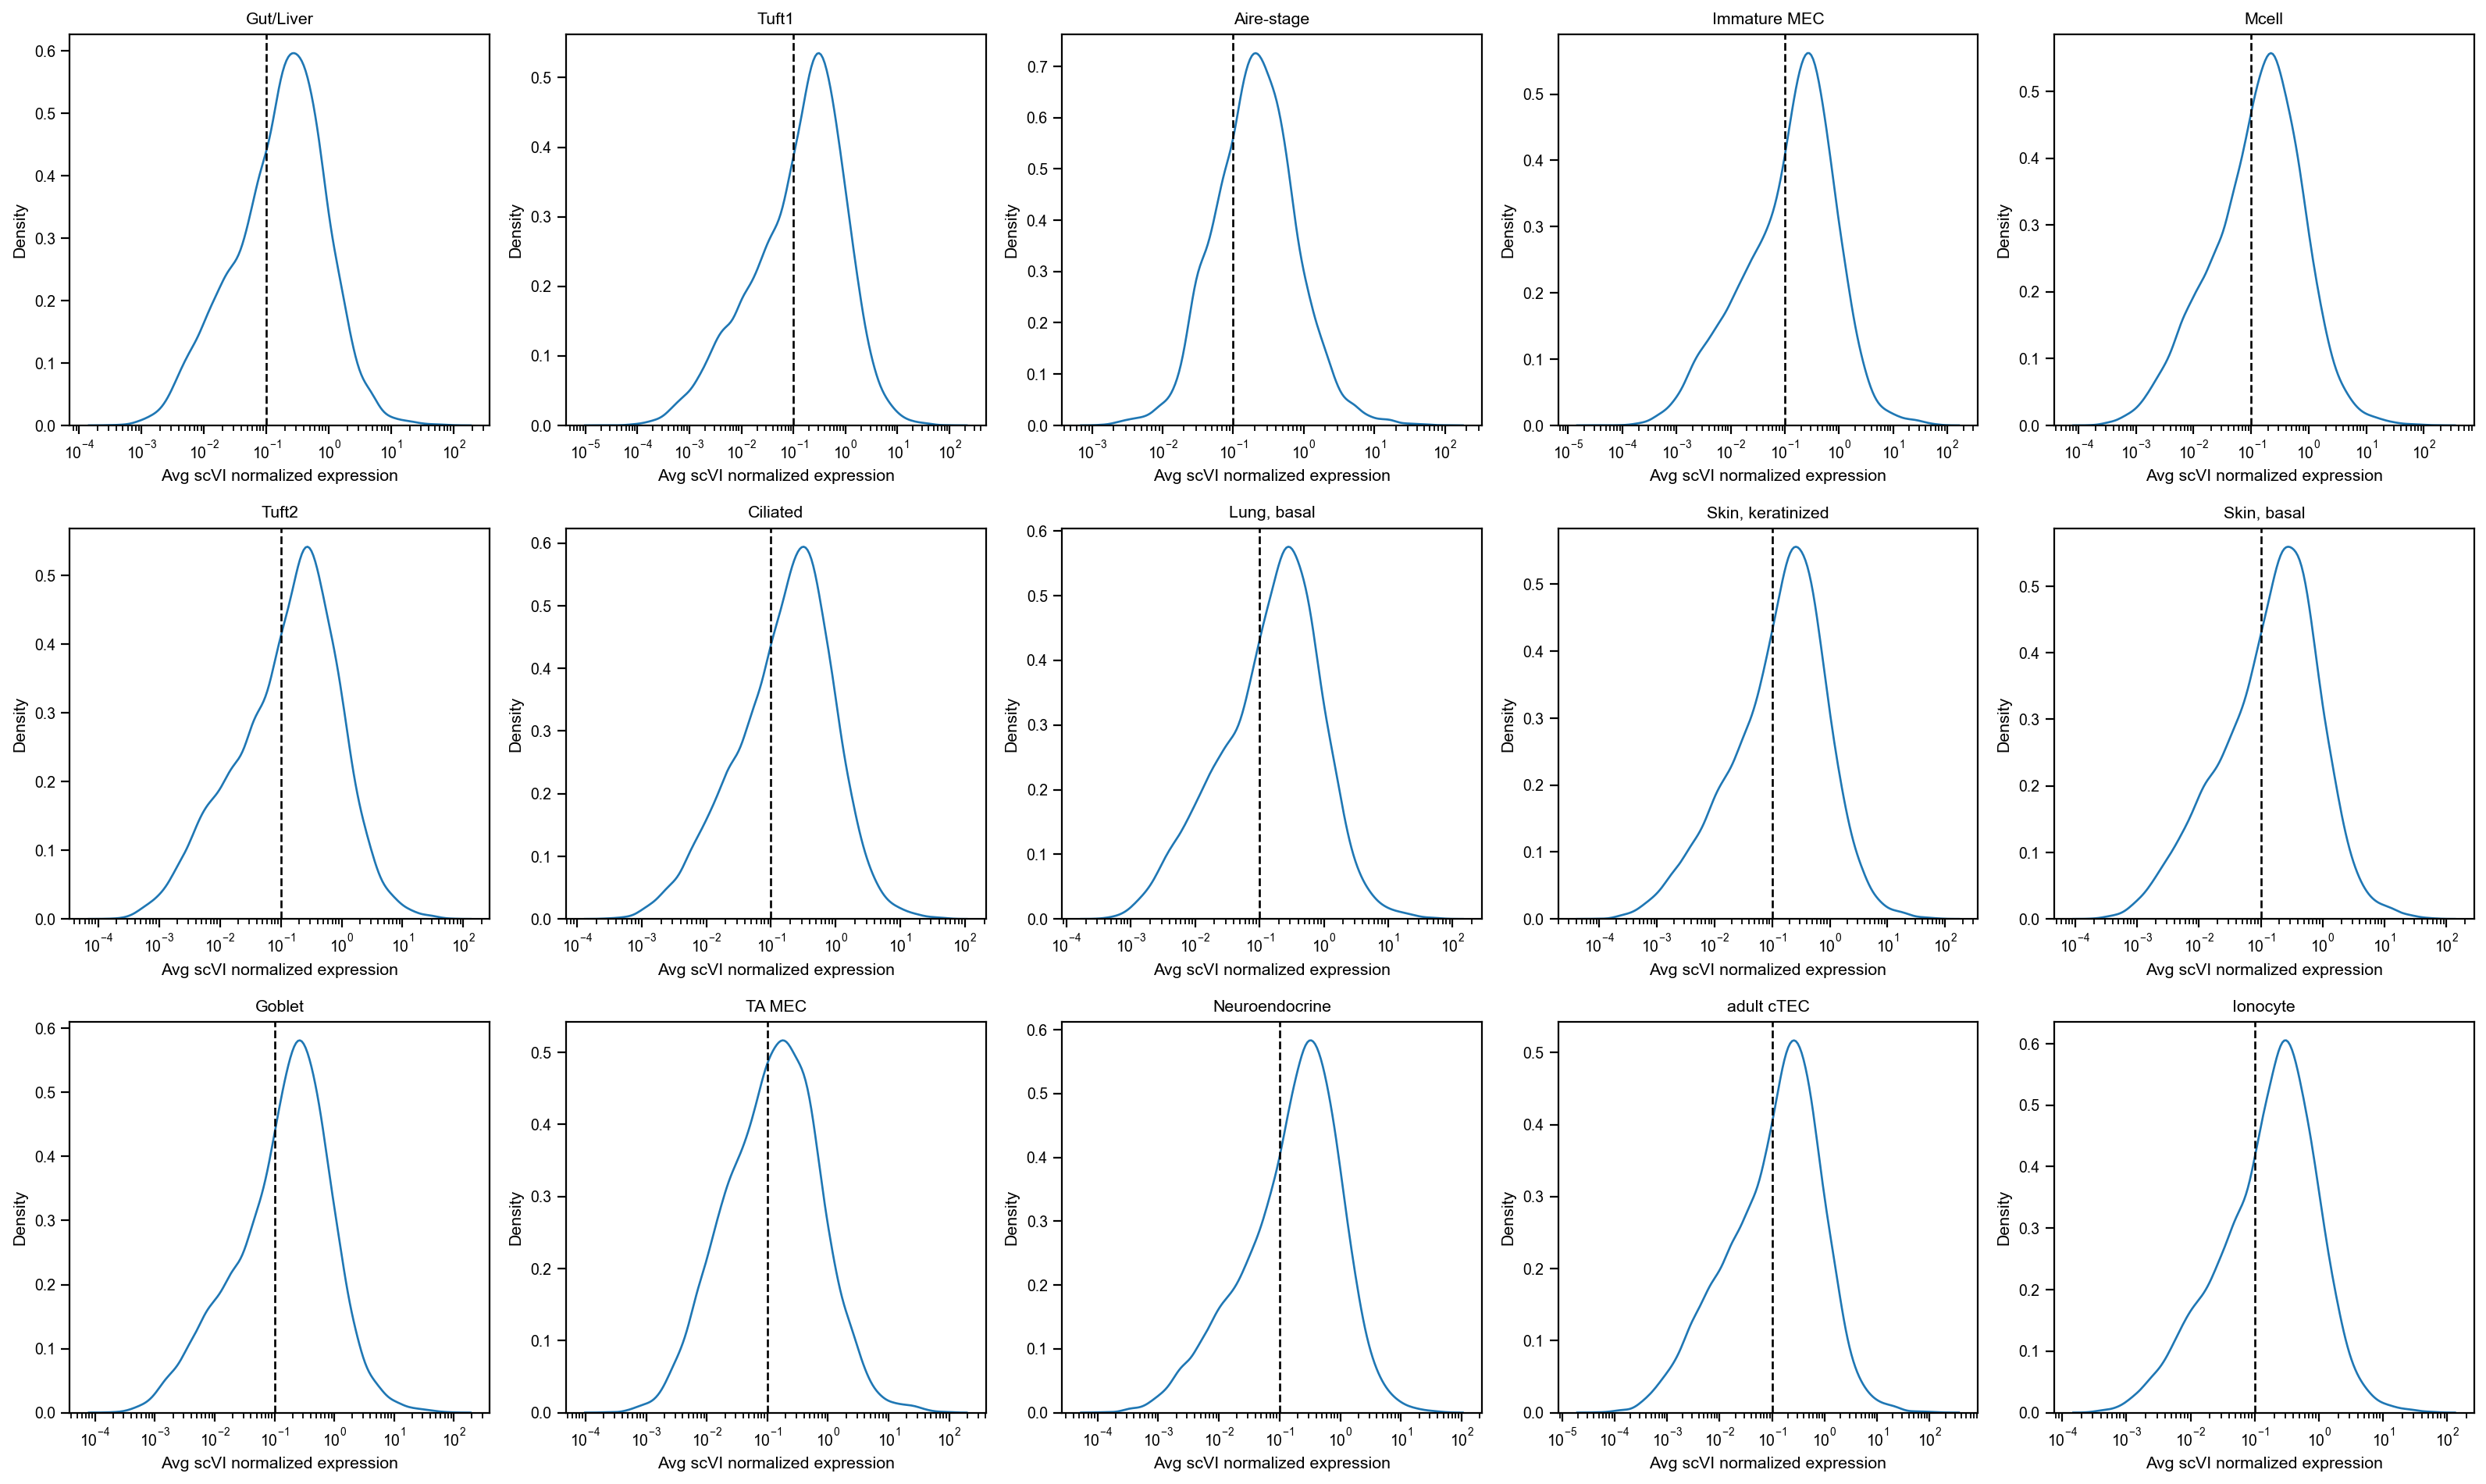

In [10]:
ncols = 5
nrows = math.ceil(len(adata.obs.majority_voting.unique())/ncols)
plt.figure(figsize=(4*ncols, 4*nrows))
for i,cell_type in enumerate(adata.obs.majority_voting.unique()):
    data = rna.tl.get_expression_matrix(
        adata[(adata.obs.genotype == "WT") & (adata.obs.majority_voting == cell_type)],
        gene_data="scVI_normalized"
    ).mean(axis=0)
    plt.subplot(nrows, ncols, i+1)
    ax = sns.kdeplot(data, log_scale=True)
    ax.set_title(cell_type)
    ax.set_xlabel("Avg scVI normalized expression")
    plt.axvline(x=0.1, color="black", linestyle="--")
plt.tight_layout()
plt.show()

## plot num genes by genotype and cluster

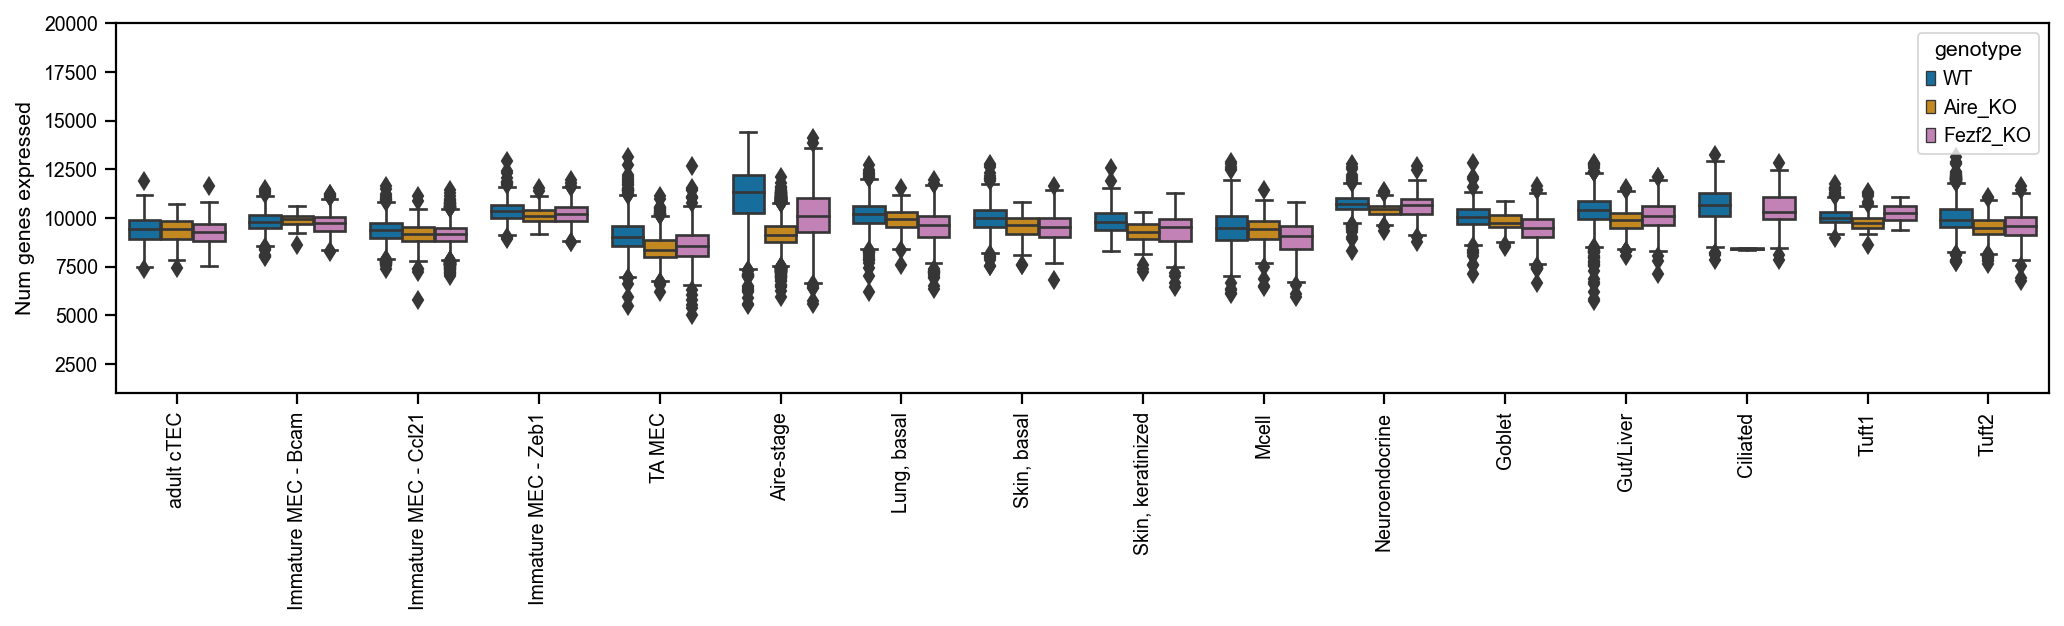

In [11]:
exprs = rna.tl.get_expression_matrix(
    adata, 
    gene_data="scVI_normalized"
)
exprs = exprs > 0.1
exprs = pd.DataFrame(exprs.sum(axis=1))
exprs["cell_type"] = adata.obs.subclustered
exprs["genotype"] = adata.obs.genotype

plt.figure(figsize=(13,4))
sns.boxplot(
    exprs,
    x="cell_type",
    y=0,
    hue="genotype",
    hue_order=["WT", "Aire_KO", "Fezf2_KO"],
    palette=cmap[0:2] + [cmap[4]],
    order=["adult cTEC", "Immature MEC - Bcam", "Immature MEC - Ccl21",
           "Immature MEC - Zeb1", "TA MEC", "Aire-stage", "Lung, basal",
           "Skin, basal", "Skin, keratinized", "Mcell", "Neuroendocrine", "Goblet",
           "Gut/Liver", "Ciliated", "Tuft1", "Tuft2"]
)
plt.xlabel("")
plt.ylabel("Num genes expressed")
plt.xticks(rotation=90)
plt.ylim(1000, 20000)
plt.tight_layout()
plt.savefig("../../analysis/paper_figures/S3/S3A_num_genes_expressed.pdf")
plt.show()

In [12]:
for cell_type in exprs.cell_type.unique():
    subset_data = exprs[exprs.cell_type == cell_type]
    wt_data = subset_data[subset_data.genotype == "WT"]
    aireko_data = subset_data[subset_data.genotype == "Aire_KO"]
    fezf2ko_data = subset_data[subset_data.genotype == "Fezf2_KO"]
    print(cell_type)
    
    print(tukey_hsd(wt_data[0], aireko_data[0], fezf2ko_data[0]))
    print()

Gut/Liver
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    520.958     0.000   461.738   580.178
 (0 - 2)    259.932     0.000   173.147   346.718
 (1 - 0)   -520.958     0.000  -580.178  -461.738
 (1 - 2)   -261.025     0.000  -353.485  -168.566
 (2 - 0)   -259.932     0.000  -346.718  -173.147
 (2 - 1)    261.025     0.000   168.566   353.485


Tuft1
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)    271.039     0.000   179.972   362.106
 (0 - 2)   -218.277     0.019  -408.150   -28.404
 (1 - 0)   -271.039     0.000  -362.106  -179.972
 (1 - 2)   -489.316     0.000  -690.652  -287.980
 (2 - 0)    218.277     0.019    28.404   408.150
 (2 - 1)    489.316     0.000   287.980   690.652


Aire-stage
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)   2049

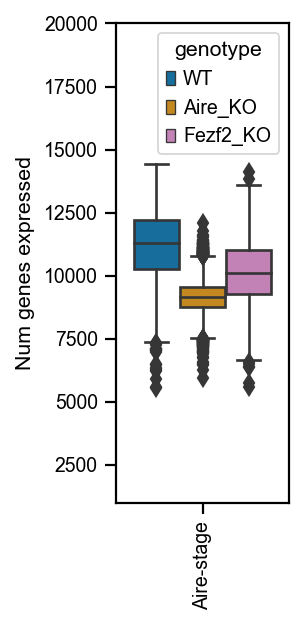

In [13]:
exprs = rna.tl.get_expression_matrix(
    adata[adata.obs.subclustered == "Aire-stage"], 
    gene_data="scVI_normalized"
)
exprs = exprs > 0.1
exprs = pd.DataFrame(exprs.sum(axis=1))
exprs["cell_type"] = adata.obs.subclustered
exprs.cell_type = exprs.cell_type.cat.remove_unused_categories()
exprs["genotype"] = adata.obs.genotype

plt.figure(figsize=(2,4))
sns.boxplot(
    exprs,
    x="cell_type",
    y=0,
    hue="genotype",
    palette=cmap[0:2] + [cmap[4]],
    hue_order=["WT", "Aire_KO", "Fezf2_KO"],
)
plt.xlabel("")
plt.ylabel("Num genes expressed")
plt.xticks(rotation=90)
plt.ylim(1000, 20000)
plt.tight_layout()
plt.savefig("../../analysis/paper_figures/2/2A_Aire-stage_num_genes_expressed.pdf")
plt.show()

# Raw data validation

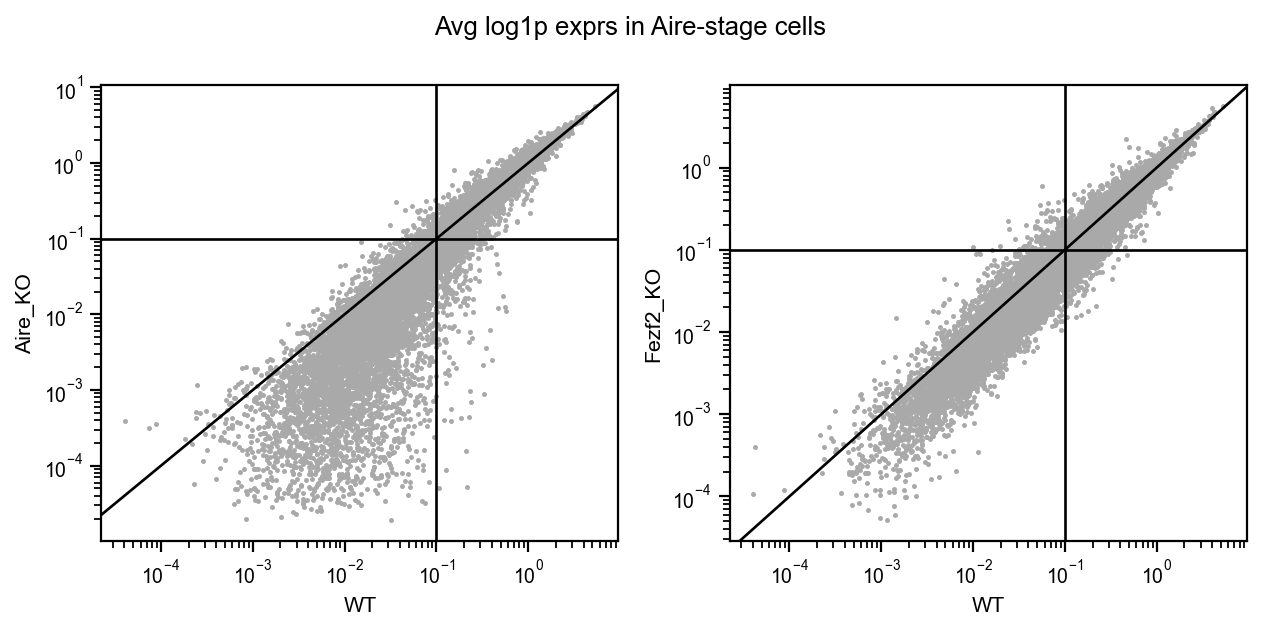

In [14]:
exprs = rna.tl.get_expression_matrix(
    adata[adata.obs.subclustered == "Aire-stage"],
    gene_data="log1p",
)
exprs["genotype"] = adata.obs.genotype
exprs = exprs.groupby("genotype").mean()

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
sns.scatterplot(exprs.T, x="WT", y="Aire_KO", s=5, c="darkgrey", linewidth=0) 
plt.axline([0,0], slope=1, c="black")
plt.axhline(y=0.1, c="black")
plt.axvline(x=0.1, c="black")
plt.xscale("log")
plt.yscale("log")

plt.subplot(1,2,2)
sns.scatterplot(exprs.T, x="WT", y="Fezf2_KO", s=5, c="darkgrey", linewidth=0) 
plt.axline([0,0], slope=1, c="black")
plt.axhline(y=0.1, c="black")
plt.axvline(x=0.1, c="black")
plt.xscale("log")
plt.yscale("log")

plt.suptitle("Avg log1p exprs in Aire-stage cells")
plt.tight_layout()
plt.savefig("../../analysis/paper_figures/2/2B_avg_log1p_Aire-stage_expression.pdf")
plt.show()

# Cell x gene epithelial cells

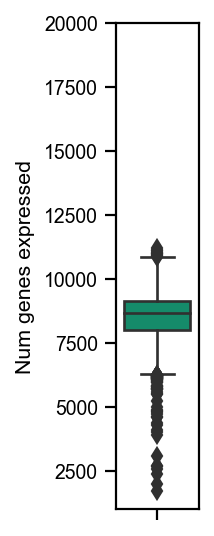

In [15]:
cell_x_gene_num_genes = cell_x_gene_exprs >= 0.1
cell_x_gene_num_genes["num_genes"] = cell_x_gene_num_genes.sum(axis=1)

plt.figure(figsize=(0.66,4))
sns.boxplot(
    cell_x_gene_num_genes,
    y="num_genes",
    palette=[cmap[2]],
)
plt.ylim(1000, 20000)
plt.xlabel("")
plt.ylabel("Num genes expressed")
plt.xticks(rotation=90)
plt.savefig("../../analysis/paper_figures/S3/S3A_cell_x_gene_num_genes_expressed.pdf")
plt.show()